In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


sns.set_theme(palette="Set2", font_scale=1.2)

Рассмотрим датасет [NYC Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data). Этот датасет содержит данные о поездках жёлтых такси в Нью-Йорке за 2016 год. Его собрала компания NYC Taxi and Limousine Commission (TLC) — официальный регулятор такси в Нью-Йорке. Информация включает время и место начала и окончания поездки, её длительность, расстояние, количество пассажиров, тип поставщика и другие характеристики.

Изначально данные использовались в конкурсе на Kaggle, где участникам нужно было создать модель для прогнозирования времени поездки. Набор данных полезен для анализа городского трафика, регрессионных задач, прогнозирования спроса на такси, оценки загруженности районов, моделирования пробок и анализа транспортной инфраструктуры.

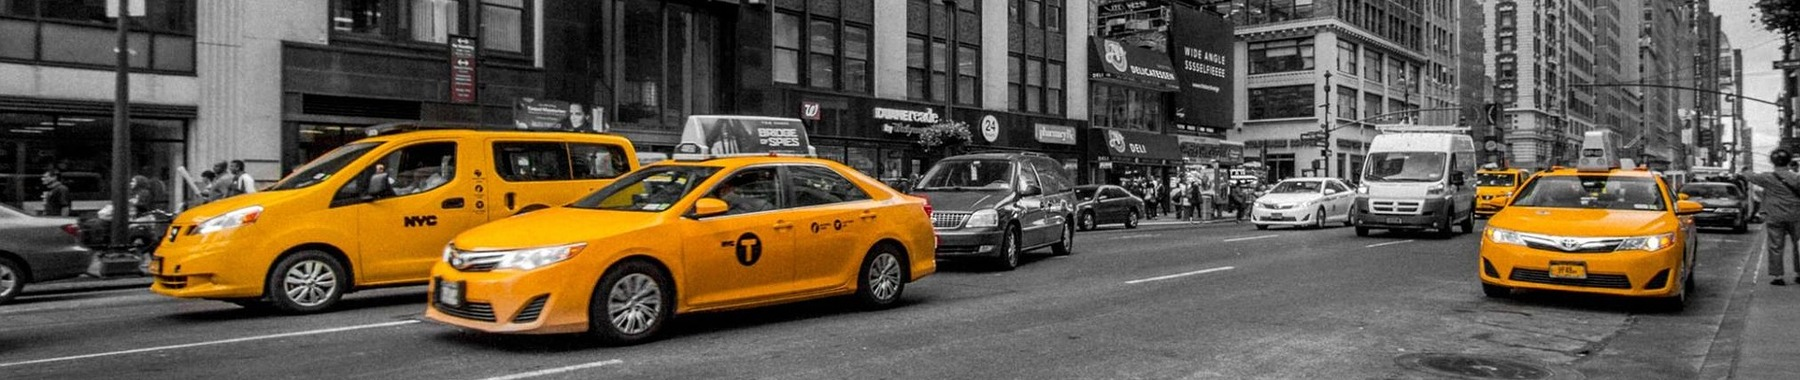

**Описание признаков**

* `id` — уникальный идентификатор поездки;  
* `vendor_id` — идентификатор поставщика (`1` или `2`, разные операторы такси);  
* `pickup_datetime` — дата и время начала поездки;  
* `dropoff_datetime` — дата и время завершения поездки;  
* `passenger_count` — количество пассажиров в машине;  
* `pickup_longitude`, `pickup_latitude` — координаты точки посадки пассажира;  
* `dropoff_longitude`, `dropoff_latitude` — координаты точки высадки пассажира;  
* `store_and_fwd_flag` — индикатор, сохранялись ли данные поездки локально перед передачей (`Y`/`N`);  
* `trip_duration` — длительность поездки в секундах (**таргет**).

**Задача**

Построить модель регрессии для прогнозирования длительности поездки по признакам, доступным в начале поездки — например, по времени, координатам и числу пассажиров.

Также практический интерес представляет построение предсказательных интервалов, позволяющих оценить диапазон возможной продолжительности поездки для конкретного маршрута. Например, *"Поездка от Центрального парка до аэропорта Ла-Гуардия в 8 утра обычно длится от 23 до 27 минут."*


---

Скачаем данные и посмотрим на них

In [3]:
df = pd.read_csv("train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
df.shape

(1458644, 11)

Данных довольно много. Для отладки кода рекомендуем работать с небольшой подвыборкой

In [5]:
# Убери этот код для финального прогона
df = df.sample(n=20_000, random_state=42).reset_index(drop=True)

**2. Первичный анализ данных (EDA)**

Посмотрим на типы данных и наличие пропусков.
Выведите информацию о датафрейме с помощью метода `info()`.
Также посмотрите на основные статистические характеристики данных с помощью `describe()`.

Обратите внимание на типы данных в колонках `pickup_datetime` и `dropoff_datetime`.


In [ ]:
# Посмотрите на общую информацию о данных
# df.info()

# Посмотрите на статистические характеристики
# df.describe()


**3. Анализ целевой переменной (Trip Duration)**

Наша целевая переменная — `trip_duration` (длительность поездки в секундах).
Постройте гистограмму распределения этой величины.
Что вы видите? Есть ли выбросы? Насколько распределение скошено?

*Подсказка: попробуйте использовать логарифмическую шкалу или логарифмирование целевой переменной `np.log1p` для визуализации.*


In [ ]:
# Постройте гистограмму целевой переменной
# plt.figure(figsize=(10, 6))
# sns.histplot(df['trip_duration'], bins=..., kde=True)
# plt.title('Distribution of Trip Duration')
# plt.show()

# Попробуйте логарифмирование
# df['log_trip_duration'] = np.log1p(df['trip_duration'])
# ... постройте график для логарифмированной переменной ...


**4. Работа с признаками (Feature Engineering)**

**4.1. Работа с датой и временем**

У нас есть колонки `pickup_datetime` и `dropoff_datetime`.
Подумайте, какие признаки можно извлечь из даты и времени, которые могут влиять на длительность поездки?

*Подсказка: используйте аксессор `.dt` для колонок с датой (например, `df['pickup_datetime'].dt.hour`).*


In [ ]:
# Пример извлечения часа поездки
# df['hour'] = df['pickup_datetime'].dt.hour

# Добавьте другие признаки на основе времени (день недели, месяц и т.д.)
# ...


**4.2. Геоданные**

У нас есть координаты начала и конца поездки.
Расстояние — один из самых важных признаков.
Однако, просто евклидово расстояние не совсем корректно для координат на сфере (Земле).
Используем формулу Haversine для вычисления расстояния по дуге большого круга.

$$
d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\varphi}{2}\right) + \cos \varphi_1 \cos \varphi_2 \sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)
$$

Ниже приведена функция для вычисления этого расстояния.
Используйте её, чтобы создать новый признак `distance_km`.


In [ ]:
from typing import Union
Coordinate = Union[float, np.ndarray, pd.Series]

def haversine(lat1: Coordinate, lon1: Coordinate, lat2: Coordinate, lon2: Coordinate) -> np.ndarray:
    """
    Вычисляет расстояние между двумя точками на Земле по формуле гаверсина.
    """
    R = 6371.0  # Средний радиус Земли в километрах

    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


In [ ]:
# Создайте колонку distance_km используя функцию haversine
# df['distance_km'] = haversine(
#     df['...'], df['...'],
#     df['...'], df['...']
# )


**4.3. Скорость и выбросы**

Теперь, когда у нас есть расстояние и время, мы можем вычислить среднюю скорость поездки.
Это поможет нам найти ошибки в данных.
1. Вычислите скорость (км/ч).
2. Постройте гистограмму скорости.
3. Есть ли нереалистичные значения? (Например, > 100 км/ч в городе или < 0).
4. Удалите явные выбросы из датасета.

*Примечание: Скорость нельзя использовать как признак для модели, так как она вычисляется с использованием целевой переменной (времени), которой не будет на этапе предсказания. Но она полезна для чистки данных.*


In [ ]:
# Вычислите скорость
# df['speed_kmh'] = ...

# Постройте график распределения скорости
# ...

# Отфильтруйте выбросы
# df = df[ (df['speed_kmh'] > ...) & (df['speed_kmh'] < ...) ]


**5. Дополнительные признаки и категориальные переменные**

Посмотрите на колонку `store_and_fwd_flag`. Это категориальный признак.
Преобразуйте его в числовой.

Подумайте, какие еще признаки можно добавить, используя имеющиеся данные?
Попробуйте реализовать свои идеи.


In [ ]:
# Преобразование категориального признака
# df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# Ваши новые признаки
# ...


**6. Подготовка к обучению**

Разделите данные на обучающую и тестовую части.
Не забудьте удалить колонки, которые нельзя использовать при обучении (например, `pickup_datetime`, `trip_duration` (это таргет), `speed` (вычислен через таргет)).


In [ ]:
from sklearn.model_selection import train_test_split

# Определите список колонок, которые нужно исключить из признаков
# exclude_cols = [...]

# Определите X (признаки) и y (целевая переменная)
# X = ...
# y = ...

# Разделите данные на train и test
# X_train, X_test, y_train, y_test = train_test_split(...)


**7. Обучение модели и анализ результатов**


Обучите линейную регрессию без регуляризации и посчитайте качество по метрике $R^2$, а также ошибки $RMSE, MAE, MAPE$ на тестовой выборке. При правильном препроцессинге можно получить $MAPE \sim 20\%$.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Инициализация модели
# model = LinearRegression()

# Обучение модели
# model.fit(X_train, y_train)

# Предсказание
# y_pred = model.predict(X_test)

# Оценка качества
# print(f"R2: {r2_score(y_test, y_pred)}")
# print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
